In [1]:
trial_number_ml = "010"
random_state_init = 1001

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model2_files = ['../../data_for_ml/ml_datasets_set2/model2_rna_bin_protein_bin/data.pkl']

# Load datasets
model2_df = load_and_concatenate_datasets(model2_files)

# Preprocess datasets
X2, y2 = preprocess_data(model2_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X2, y2)

# Output shapes
print(f"Model 2 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 2 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 19:13:25,347] A new study created in memory with name: no-name-5d3337bc-5f3e-400a-af67-5584decb229b


[I 2024-05-01 19:13:44,817] Trial 1 finished with value: 0.8189371082599377 and parameters: {'n_estimators': 131, 'max_depth': 41, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 1 with value: 0.8189371082599377.


[I 2024-05-01 19:14:14,371] Trial 2 finished with value: 0.8237162100387042 and parameters: {'n_estimators': 356, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 2 with value: 0.8237162100387042.


[I 2024-05-01 19:14:57,642] Trial 3 finished with value: 0.8763117260435397 and parameters: {'n_estimators': 490, 'max_depth': 60, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.8763117260435397.


[I 2024-05-01 19:15:00,716] Trial 5 finished with value: 0.8412428001097126 and parameters: {'n_estimators': 298, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.8763117260435397.


[I 2024-05-01 19:15:10,004] Trial 0 finished with value: 0.8641991487113847 and parameters: {'n_estimators': 681, 'max_depth': 97, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 3 with value: 0.8763117260435397.


[I 2024-05-01 19:15:13,279] Trial 4 finished with value: 0.8476183220065219 and parameters: {'n_estimators': 559, 'max_depth': 76, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.8763117260435397.


[I 2024-05-01 19:15:16,397] Trial 8 pruned. 


[I 2024-05-01 19:15:18,548] Trial 6 finished with value: 0.8520855555216936 and parameters: {'n_estimators': 132, 'max_depth': 92, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 3 with value: 0.8763117260435397.


[I 2024-05-01 19:15:38,338] Trial 7 finished with value: 0.8578210871707352 and parameters: {'n_estimators': 223, 'max_depth': 36, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.8763117260435397.


[I 2024-05-01 19:15:44,251] Trial 11 pruned. 


[I 2024-05-01 19:15:58,226] Trial 12 pruned. 


[I 2024-05-01 19:16:30,194] Trial 10 finished with value: 0.8492116945519559 and parameters: {'n_estimators': 513, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.8763117260435397.


[I 2024-05-01 19:17:20,936] Trial 14 finished with value: 0.876950192505003 and parameters: {'n_estimators': 532, 'max_depth': 62, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.876950192505003.


[I 2024-05-01 19:17:40,138] Trial 13 finished with value: 0.8712095815682808 and parameters: {'n_estimators': 755, 'max_depth': 67, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.876950192505003.


[I 2024-05-01 19:17:40,895] Trial 9 finished with value: 0.8661054053779498 and parameters: {'n_estimators': 970, 'max_depth': 43, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.876950192505003.


[I 2024-05-01 19:18:05,690] Trial 15 finished with value: 0.8724844827761356 and parameters: {'n_estimators': 639, 'max_depth': 59, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.876950192505003.


[I 2024-05-01 19:18:30,856] Trial 16 finished with value: 0.8715285608346287 and parameters: {'n_estimators': 460, 'max_depth': 61, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.876950192505003.


[I 2024-05-01 19:18:48,552] Trial 17 finished with value: 0.8581400664370828 and parameters: {'n_estimators': 454, 'max_depth': 55, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.876950192505003.


[I 2024-05-01 19:18:50,407] Trial 18 finished with value: 0.858776501183474 and parameters: {'n_estimators': 461, 'max_depth': 58, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.876950192505003.


[I 2024-05-01 19:19:14,916] Trial 19 finished with value: 0.858776501183474 and parameters: {'n_estimators': 456, 'max_depth': 56, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.876950192505003.


[I 2024-05-01 19:19:32,158] Trial 20 finished with value: 0.8594149676449374 and parameters: {'n_estimators': 411, 'max_depth': 51, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.876950192505003.


[I 2024-05-01 19:19:47,148] Trial 22 finished with value: 0.8635550950334725 and parameters: {'n_estimators': 384, 'max_depth': 73, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.876950192505003.


[I 2024-05-01 19:19:47,529] Trial 21 finished with value: 0.8667469194120215 and parameters: {'n_estimators': 398, 'max_depth': 73, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.876950192505003.


[I 2024-05-01 19:20:04,879] Trial 23 finished with value: 0.8645150804051239 and parameters: {'n_estimators': 350, 'max_depth': 75, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.876950192505003.


[I 2024-05-01 19:20:59,619] Trial 24 finished with value: 0.8769507004337711 and parameters: {'n_estimators': 615, 'max_depth': 71, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 24 with value: 0.8769507004337711.


[I 2024-05-01 19:21:12,512] Trial 25 finished with value: 0.8734414205751786 and parameters: {'n_estimators': 611, 'max_depth': 65, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 24 with value: 0.8769507004337711.


[I 2024-05-01 19:21:13,334] Trial 26 finished with value: 0.8747188614268735 and parameters: {'n_estimators': 614, 'max_depth': 48, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 24 with value: 0.8769507004337711.


[I 2024-05-01 19:21:27,785] Trial 27 finished with value: 0.8769501925050033 and parameters: {'n_estimators': 598, 'max_depth': 47, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 24 with value: 0.8769507004337711.


[I 2024-05-01 19:21:49,187] Trial 31 pruned. 


[I 2024-05-01 19:22:07,000] Trial 32 pruned. 


[I 2024-05-01 19:22:24,510] Trial 28 finished with value: 0.8782256016416259 and parameters: {'n_estimators': 583, 'max_depth': 84, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8782256016416259.


[I 2024-05-01 19:23:06,257] Trial 30 finished with value: 0.8696146852365423 and parameters: {'n_estimators': 788, 'max_depth': 68, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8782256016416259.


[I 2024-05-01 19:23:11,408] Trial 29 finished with value: 0.8782250937128577 and parameters: {'n_estimators': 809, 'max_depth': 87, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8782256016416259.


[I 2024-05-01 19:23:24,860] Trial 33 finished with value: 0.8670648828208332 and parameters: {'n_estimators': 555, 'max_depth': 94, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8782256016416259.


[I 2024-05-01 19:23:26,301] Trial 35 pruned. 


[I 2024-05-01 19:23:37,075] Trial 36 pruned. 


[I 2024-05-01 19:23:42,638] Trial 34 finished with value: 0.8683387681711517 and parameters: {'n_estimators': 542, 'max_depth': 91, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8782256016416259.


[I 2024-05-01 19:23:47,658] Trial 37 pruned. 


[I 2024-05-01 19:23:49,229] Trial 38 pruned. 


[I 2024-05-01 19:23:57,959] Trial 39 pruned. 


[I 2024-05-01 19:24:03,971] Trial 40 pruned. 


[I 2024-05-01 19:24:07,776] Trial 41 pruned. 


[I 2024-05-01 19:24:15,087] Trial 43 pruned. 


[I 2024-05-01 19:25:26,058] Trial 46 finished with value: 0.8721660114385559 and parameters: {'n_estimators': 515, 'max_depth': 26, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8782256016416259.


[I 2024-05-01 19:25:31,767] Trial 45 finished with value: 0.8747158138542652 and parameters: {'n_estimators': 604, 'max_depth': 29, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8782256016416259.


[I 2024-05-01 19:25:32,441] Trial 42 finished with value: 0.8782256016416257 and parameters: {'n_estimators': 696, 'max_depth': 80, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8782256016416259.


[I 2024-05-01 19:25:35,233] Trial 44 finished with value: 0.8772691717713508 and parameters: {'n_estimators': 618, 'max_depth': 76, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8782256016416259.


[I 2024-05-01 19:25:42,090] Trial 48 pruned. 


[I 2024-05-01 19:26:01,901] Trial 47 finished with value: 0.8728034620424833 and parameters: {'n_estimators': 567, 'max_depth': 90, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8782256016416259.


[I 2024-05-01 19:26:05,284] Trial 49 finished with value: 0.8724844827761356 and parameters: {'n_estimators': 654, 'max_depth': 90, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.8782256016416259.


Best trial for RandomForestClassifier:
  Value: 0.8782256016416259
  Params: 
    n_estimators: 583
    max_depth: 84
    min_samples_split: 15
    min_samples_leaf: 1
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 583, 'max_depth': 84, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2024-05-01 19:26:14,307] A new study created in memory with name: no-name-a689832d-0e75-45c0-bf96-36fae96418be


RandomForestClassifier accuracy: 0.8624



[I 2024-05-01 19:26:17,750] Trial 3 finished with value: 0.834558457521917 and parameters: {'n_estimators': 117, 'max_depth': 9, 'learning_rate': 0.11879262182114353, 'min_child_weight': 8, 'subsample': 0.5720643708952817, 'colsample_bytree': 0.7096078465777633, 'gamma': 3.244120099818048, 'reg_lambda': 6.340766188191609, 'reg_alpha': 1.2892103210416808}. Best is trial 3 with value: 0.834558457521917.


[I 2024-05-01 19:26:17,901] Trial 0 finished with value: 0.8581441298672274 and parameters: {'n_estimators': 156, 'max_depth': 8, 'learning_rate': 0.22359065113288346, 'min_child_weight': 7, 'subsample': 0.7483095820618699, 'colsample_bytree': 0.6634501690518074, 'gamma': 2.536301583409637, 'reg_lambda': 0.03531503267863173, 'reg_alpha': 0.4529885182214341}. Best is trial 0 with value: 0.8581441298672274.


[I 2024-05-01 19:26:18,775] Trial 2 finished with value: 0.8501747274962159 and parameters: {'n_estimators': 259, 'max_depth': 9, 'learning_rate': 0.19431729638670886, 'min_child_weight': 6, 'subsample': 0.5800996850496096, 'colsample_bytree': 0.8273797723736704, 'gamma': 4.640935891419195, 'reg_lambda': 0.21344951989393354, 'reg_alpha': 1.1131135679742317}. Best is trial 0 with value: 0.8581441298672274.


[I 2024-05-01 19:26:21,007] Trial 1 finished with value: 0.8763132498298439 and parameters: {'n_estimators': 358, 'max_depth': 10, 'learning_rate': 0.13352222518284085, 'min_child_weight': 1, 'subsample': 0.6074410041630265, 'colsample_bytree': 0.9578846467550743, 'gamma': 1.7793726924063924, 'reg_lambda': 0.4407465477222246, 'reg_alpha': 0.24338442586638237}. Best is trial 1 with value: 0.8763132498298439.


[I 2024-05-01 19:26:23,435] Trial 6 finished with value: 0.8109621186724774 and parameters: {'n_estimators': 275, 'max_depth': 7, 'learning_rate': 0.04568148694276044, 'min_child_weight': 3, 'subsample': 0.8677466866787812, 'colsample_bytree': 0.5410454596463716, 'gamma': 4.968705936029675, 'reg_lambda': 4.122911231574518, 'reg_alpha': 9.835256458549818}. Best is trial 1 with value: 0.8763132498298439.


[I 2024-05-01 19:26:24,161] Trial 4 finished with value: 0.864200672497689 and parameters: {'n_estimators': 485, 'max_depth': 10, 'learning_rate': 0.12773759288745357, 'min_child_weight': 3, 'subsample': 0.9124433106188352, 'colsample_bytree': 0.9571810623727502, 'gamma': 4.400404269138119, 'reg_lambda': 0.37354316490021483, 'reg_alpha': 0.975704470883856}. Best is trial 1 with value: 0.8763132498298439.


[I 2024-05-01 19:26:24,717] Trial 9 pruned. 


[I 2024-05-01 19:26:27,410] Trial 5 finished with value: 0.8619703572770954 and parameters: {'n_estimators': 767, 'max_depth': 5, 'learning_rate': 0.22969066902133867, 'min_child_weight': 6, 'subsample': 0.857899055797873, 'colsample_bytree': 0.9449872492641278, 'gamma': 2.185720342544007, 'reg_lambda': 0.021060790409843003, 'reg_alpha': 0.14313135758763781}. Best is trial 1 with value: 0.8763132498298439.


[I 2024-05-01 19:26:28,417] Trial 7 finished with value: 0.8482603439693618 and parameters: {'n_estimators': 508, 'max_depth': 4, 'learning_rate': 0.25309655673881576, 'min_child_weight': 8, 'subsample': 0.6232089958548144, 'colsample_bytree': 0.7269145279629108, 'gamma': 2.28189164336301, 'reg_lambda': 0.49853610267086124, 'reg_alpha': 0.2631200425946701}. Best is trial 1 with value: 0.8763132498298439.


[I 2024-05-01 19:26:29,404] Trial 12 pruned. 


[I 2024-05-01 19:26:29,571] Trial 11 pruned. 


[I 2024-05-01 19:26:30,363] Trial 10 finished with value: 0.8708982212334542 and parameters: {'n_estimators': 357, 'max_depth': 7, 'learning_rate': 0.22049059432495205, 'min_child_weight': 1, 'subsample': 0.7074212530841707, 'colsample_bytree': 0.7857041726164982, 'gamma': 0.7265573098374206, 'reg_lambda': 0.5923906174428428, 'reg_alpha': 3.9411696432950456}. Best is trial 1 with value: 0.8763132498298439.


[I 2024-05-01 19:26:34,436] Trial 8 finished with value: 0.880776927843639 and parameters: {'n_estimators': 429, 'max_depth': 10, 'learning_rate': 0.0656037009338509, 'min_child_weight': 1, 'subsample': 0.7417255475536418, 'colsample_bytree': 0.7864554142987501, 'gamma': 0.6832931721507995, 'reg_lambda': 1.294683395235052, 'reg_alpha': 0.26081446866294467}. Best is trial 8 with value: 0.880776927843639.


[I 2024-05-01 19:26:36,755] Trial 16 pruned. 


[I 2024-05-01 19:26:39,463] Trial 14 finished with value: 0.8724875303487438 and parameters: {'n_estimators': 463, 'max_depth': 10, 'learning_rate': 0.15361521107483994, 'min_child_weight': 1, 'subsample': 0.51122060393002, 'colsample_bytree': 0.994091168265808, 'gamma': 0.6886728895337952, 'reg_lambda': 0.44718108214125424, 'reg_alpha': 0.06137564566311819}. Best is trial 8 with value: 0.880776927843639.


[I 2024-05-01 19:26:39,673] Trial 15 finished with value: 0.8705741626794259 and parameters: {'n_estimators': 426, 'max_depth': 6, 'learning_rate': 0.17714182081572993, 'min_child_weight': 1, 'subsample': 0.6413966441107033, 'colsample_bytree': 0.8446668176063192, 'gamma': 0.3481715700771848, 'reg_lambda': 1.0254698663013784, 'reg_alpha': 0.0521168048458475}. Best is trial 8 with value: 0.880776927843639.


[I 2024-05-01 19:26:44,108] Trial 13 finished with value: 0.8686597791525715 and parameters: {'n_estimators': 929, 'max_depth': 6, 'learning_rate': 0.16624191091817622, 'min_child_weight': 1, 'subsample': 0.9922983513243642, 'colsample_bytree': 0.8652724826281395, 'gamma': 0.10831171761753122, 'reg_lambda': 1.088587812472278, 'reg_alpha': 0.013202173183040488}. Best is trial 8 with value: 0.880776927843639.


[I 2024-05-01 19:26:47,306] Trial 17 finished with value: 0.8648376151728481 and parameters: {'n_estimators': 660, 'max_depth': 3, 'learning_rate': 0.07474866084044005, 'min_child_weight': 4, 'subsample': 0.6425976724903193, 'colsample_bytree': 0.9985831573788997, 'gamma': 1.272911497989898, 'reg_lambda': 0.09409373485514674, 'reg_alpha': 0.04952060057886147}. Best is trial 8 with value: 0.880776927843639.


[I 2024-05-01 19:26:49,159] Trial 18 finished with value: 0.8654765895630797 and parameters: {'n_estimators': 599, 'max_depth': 3, 'learning_rate': 0.07657506151192661, 'min_child_weight': 4, 'subsample': 0.6485282953848988, 'colsample_bytree': 0.8816423875428612, 'gamma': 1.226833581756671, 'reg_lambda': 0.12366483470954338, 'reg_alpha': 0.027059234619604886}. Best is trial 8 with value: 0.880776927843639.


[I 2024-05-01 19:26:50,352] Trial 19 finished with value: 0.8686643505114843 and parameters: {'n_estimators': 669, 'max_depth': 3, 'learning_rate': 0.07872175922920548, 'min_child_weight': 4, 'subsample': 0.8172844167923492, 'colsample_bytree': 0.9033125783167408, 'gamma': 1.3865194698495964, 'reg_lambda': 0.113713615687061, 'reg_alpha': 0.023592919495842996}. Best is trial 8 with value: 0.880776927843639.


[I 2024-05-01 19:26:52,584] Trial 21 finished with value: 0.8756763071546846 and parameters: {'n_estimators': 183, 'max_depth': 8, 'learning_rate': 0.09160787922174299, 'min_child_weight': 4, 'subsample': 0.8422205219056247, 'colsample_bytree': 0.8995342132336928, 'gamma': 1.459961429095443, 'reg_lambda': 0.10456042556193546, 'reg_alpha': 0.16031501758066916}. Best is trial 8 with value: 0.880776927843639.


[I 2024-05-01 19:26:54,193] Trial 22 finished with value: 0.8731259968102074 and parameters: {'n_estimators': 199, 'max_depth': 8, 'learning_rate': 0.11455257744708339, 'min_child_weight': 2, 'subsample': 0.8017949655032499, 'colsample_bytree': 0.5810230673011207, 'gamma': 1.5215156960699876, 'reg_lambda': 1.9528662589852035, 'reg_alpha': 0.1358349757635441}. Best is trial 8 with value: 0.880776927843639.


[I 2024-05-01 19:26:54,616] Trial 20 finished with value: 0.8670669145359055 and parameters: {'n_estimators': 663, 'max_depth': 3, 'learning_rate': 0.07557581739047807, 'min_child_weight': 4, 'subsample': 0.8111958076754469, 'colsample_bytree': 0.9235792445956419, 'gamma': 1.3669852891683563, 'reg_lambda': 0.10474904662928579, 'reg_alpha': 0.139828279993278}. Best is trial 8 with value: 0.880776927843639.


[I 2024-05-01 19:26:55,227] Trial 23 finished with value: 0.8743973425166855 and parameters: {'n_estimators': 201, 'max_depth': 8, 'learning_rate': 0.11979177436206823, 'min_child_weight': 2, 'subsample': 0.7912842684940521, 'colsample_bytree': 0.7940090650072034, 'gamma': 1.8025371393197935, 'reg_lambda': 1.8431725474968041, 'reg_alpha': 0.16173605052771395}. Best is trial 8 with value: 0.880776927843639.


[I 2024-05-01 19:26:56,088] Trial 25 pruned. 


[I 2024-05-01 19:26:56,221] Trial 26 pruned. 


[I 2024-05-01 19:26:57,000] Trial 29 pruned. 


[I 2024-05-01 19:26:57,736] Trial 24 finished with value: 0.8743973425166855 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.11592688975849896, 'min_child_weight': 2, 'subsample': 0.7971549742469993, 'colsample_bytree': 0.7929341992856952, 'gamma': 1.8071517963221595, 'reg_lambda': 2.2144927264529737, 'reg_alpha': 0.19474334792619796}. Best is trial 8 with value: 0.880776927843639.


[I 2024-05-01 19:26:58,029] Trial 30 pruned. 


[I 2024-05-01 19:26:58,919] Trial 31 pruned. 


[I 2024-05-01 19:26:59,133] Trial 32 pruned. 


[I 2024-05-01 19:26:59,797] Trial 33 pruned. 


[I 2024-05-01 19:27:00,001] Trial 34 pruned. 


[I 2024-05-01 19:27:02,627] Trial 28 finished with value: 0.8747208931419458 and parameters: {'n_estimators': 313, 'max_depth': 10, 'learning_rate': 0.14657006448183907, 'min_child_weight': 5, 'subsample': 0.9183793274686876, 'colsample_bytree': 0.9615167926871987, 'gamma': 0.9605525379259721, 'reg_lambda': 0.8058928590100694, 'reg_alpha': 0.5103919639713294}. Best is trial 8 with value: 0.880776927843639.


[I 2024-05-01 19:27:04,666] Trial 35 finished with value: 0.8699351882891943 and parameters: {'n_estimators': 216, 'max_depth': 7, 'learning_rate': 0.13074944191571888, 'min_child_weight': 1, 'subsample': 0.7642209314922348, 'colsample_bytree': 0.7649163981448981, 'gamma': 1.6065682780138058, 'reg_lambda': 0.2956875212163807, 'reg_alpha': 0.10402513921257094}. Best is trial 8 with value: 0.880776927843639.


[I 2024-05-01 19:27:05,624] Trial 27 finished with value: 0.8817333577139141 and parameters: {'n_estimators': 340, 'max_depth': 10, 'learning_rate': 0.04175623535423013, 'min_child_weight': 2, 'subsample': 0.9349524106420845, 'colsample_bytree': 0.8248238719271991, 'gamma': 0.8658065139670363, 'reg_lambda': 0.2217455791529935, 'reg_alpha': 0.5678563634681928}. Best is trial 27 with value: 0.8817333577139141.


[I 2024-05-01 19:27:06,823] Trial 36 finished with value: 0.8823682686740011 and parameters: {'n_estimators': 235, 'max_depth': 9, 'learning_rate': 0.0610371743688668, 'min_child_weight': 2, 'subsample': 0.572936919321327, 'colsample_bytree': 0.8941478558838697, 'gamma': 1.7061422959035009, 'reg_lambda': 0.259851151592811, 'reg_alpha': 0.09592802434344047}. Best is trial 36 with value: 0.8823682686740011.


[I 2024-05-01 19:27:07,156] Trial 38 pruned. 


[I 2024-05-01 19:27:07,535] Trial 39 pruned. 


[I 2024-05-01 19:27:08,700] Trial 40 pruned. 


[I 2024-05-01 19:27:09,069] Trial 41 pruned. 


[I 2024-05-01 19:27:10,658] Trial 43 pruned. 


[I 2024-05-01 19:27:11,873] Trial 45 pruned. 


[I 2024-05-01 19:27:16,185] Trial 37 finished with value: 0.8699372200042665 and parameters: {'n_estimators': 397, 'max_depth': 9, 'learning_rate': 0.19290165978877885, 'min_child_weight': 7, 'subsample': 0.951804504385234, 'colsample_bytree': 0.9207098534769371, 'gamma': 0.01738779278973368, 'reg_lambda': 0.19714716063904336, 'reg_alpha': 0.6877511304017114}. Best is trial 36 with value: 0.8823682686740011.


[I 2024-05-01 19:27:16,922] Trial 46 finished with value: 0.8740798870366419 and parameters: {'n_estimators': 170, 'max_depth': 9, 'learning_rate': 0.09900763317249606, 'min_child_weight': 2, 'subsample': 0.5913948494225788, 'colsample_bytree': 0.8906174528457943, 'gamma': 1.1829358896486735, 'reg_lambda': 0.07773469038430424, 'reg_alpha': 0.035698695492880864}. Best is trial 36 with value: 0.8823682686740011.


[I 2024-05-01 19:27:17,695] Trial 42 finished with value: 0.8737639553429026 and parameters: {'n_estimators': 558, 'max_depth': 10, 'learning_rate': 0.0581693938686982, 'min_child_weight': 2, 'subsample': 0.5518695692264665, 'colsample_bytree': 0.8201858666625701, 'gamma': 2.102952580696408, 'reg_lambda': 0.2831924628898579, 'reg_alpha': 1.286199656667458}. Best is trial 36 with value: 0.8823682686740011.


[I 2024-05-01 19:27:18,465] Trial 47 pruned. 


[I 2024-05-01 19:27:19,218] Trial 49 pruned. 


[I 2024-05-01 19:27:20,939] Trial 44 finished with value: 0.8798199900445962 and parameters: {'n_estimators': 532, 'max_depth': 10, 'learning_rate': 0.06225628383695321, 'min_child_weight': 2, 'subsample': 0.604402254656397, 'colsample_bytree': 0.891895936406106, 'gamma': 1.1512735917130144, 'reg_lambda': 0.16945790828502752, 'reg_alpha': 0.3311736298785729}. Best is trial 36 with value: 0.8823682686740011.


[I 2024-05-01 19:27:25,210] Trial 48 finished with value: 0.875992238848424 and parameters: {'n_estimators': 497, 'max_depth': 10, 'learning_rate': 0.06086890590360991, 'min_child_weight': 1, 'subsample': 0.8771853656025462, 'colsample_bytree': 0.9578725373896163, 'gamma': 1.5515601315700092, 'reg_lambda': 0.039074036853252676, 'reg_alpha': 0.10501513253894883}. Best is trial 36 with value: 0.8823682686740011.


Best trial for XGBClassifier:
  Value: 0.8823682686740011
  Params: 
    n_estimators: 235
    max_depth: 9
    learning_rate: 0.0610371743688668
    min_child_weight: 2
    subsample: 0.572936919321327
    colsample_bytree: 0.8941478558838697
    gamma: 1.7061422959035009
    reg_lambda: 0.259851151592811
    reg_alpha: 0.09592802434344047

Best hyperparameters for XGBClassifier: {'n_estimators': 235, 'max_depth': 9, 'learning_rate': 0.0610371743688668, 'min_child_weight': 2, 'subsample': 0.572936919321327, 'colsample_bytree': 0.8941478558838697, 'gamma': 1.7061422959035009, 'reg_lambda': 0.259851151592811, 'reg_alpha': 0.09592802434344047}


[I 2024-05-01 19:27:26,126] A new study created in memory with name: no-name-4d0ed69e-8a56-4f03-be81-8b77f0c8ee8c


XGBClassifier accuracy: 0.8675



[I 2024-05-01 19:27:26,757] Trial 0 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'max_depth': 1, 'learning_rate': 0.49675435449742644, 'n_estimators': 525, 'min_child_weight': 0.0013806981816830374, 'min_child_samples': 1763, 'subsample': 0.8920982845975866, 'colsample_bytree': 0.8970178866167906, 'reg_alpha': 9.330118308669402e-08, 'reg_lambda': 1.7750114245547367e-10}. Best is trial 0 with value: 0.4995215311004785.


[I 2024-05-01 19:27:26,951] Trial 1 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 94, 'max_depth': 15, 'learning_rate': 0.3058949871275163, 'n_estimators': 999, 'min_child_weight': 0.005992272311499408, 'min_child_samples': 1472, 'subsample': 0.9369376968234892, 'colsample_bytree': 0.8140928413963384, 'reg_alpha': 6.551992370706469e-10, 'reg_lambda': 0.678304855744888}. Best is trial 0 with value: 0.4995215311004785.


[I 2024-05-01 19:27:27,808] Trial 5 finished with value: 0.750715163705442 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'max_depth': 0, 'learning_rate': 0.47846388824562075, 'n_estimators': 152, 'min_child_weight': 0.044405427419990345, 'min_child_samples': 616, 'subsample': 0.9525766655126775, 'colsample_bytree': 0.9307338913937717, 'reg_alpha': 0.05349386782405656, 'reg_lambda': 4.689905688286802e-09}. Best is trial 5 with value: 0.750715163705442.


[I 2024-05-01 19:27:28,205] Trial 4 finished with value: 0.6643301943335467 and parameters: {'boosting_type': 'goss', 'num_leaves': 68, 'max_depth': 9, 'learning_rate': 0.478696906771177, 'n_estimators': 758, 'min_child_weight': 0.09572990454127799, 'min_child_samples': 1068, 'subsample': 0.8098790929686702, 'colsample_bytree': 0.9912846802026811, 'reg_alpha': 0.0011203658519588512, 'reg_lambda': 0.0007156715626787922}. Best is trial 5 with value: 0.750715163705442.


[I 2024-05-01 19:27:28,487] Trial 6 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 8, 'learning_rate': 0.06713704738206322, 'n_estimators': 862, 'min_child_weight': 0.037747098896293005, 'min_child_samples': 1883, 'subsample': 0.8515032340702074, 'colsample_bytree': 0.9855461021300218, 'reg_alpha': 0.007020042802386445, 'reg_lambda': 2.41747566649141e-08}. Best is trial 5 with value: 0.750715163705442.


[I 2024-05-01 19:27:29,538] Trial 7 finished with value: 0.6697487784313128 and parameters: {'boosting_type': 'goss', 'num_leaves': 83, 'max_depth': 15, 'learning_rate': 0.4126063164315999, 'n_estimators': 445, 'min_child_weight': 0.005707161866649906, 'min_child_samples': 517, 'subsample': 0.973944924578599, 'colsample_bytree': 0.8792839760639957, 'reg_alpha': 7.583981691147028e-06, 'reg_lambda': 0.0011663912224536357}. Best is trial 5 with value: 0.750715163705442.


[I 2024-05-01 19:27:31,817] Trial 8 finished with value: 0.8211643759079227 and parameters: {'boosting_type': 'goss', 'num_leaves': 46, 'max_depth': 13, 'learning_rate': 0.21439726855334046, 'n_estimators': 311, 'min_child_weight': 0.01929680029248289, 'min_child_samples': 100, 'subsample': 0.9557897293888006, 'colsample_bytree': 0.929512932973362, 'reg_alpha': 0.0001389984018667965, 'reg_lambda': 1.2759028871329907e-06}. Best is trial 8 with value: 0.8211643759079227.


[I 2024-05-01 19:27:33,862] Trial 10 finished with value: 0.7570947490323957 and parameters: {'boosting_type': 'goss', 'num_leaves': 66, 'max_depth': 7, 'learning_rate': 0.04355535330203083, 'n_estimators': 312, 'min_child_weight': 0.001662532225118449, 'min_child_samples': 214, 'subsample': 0.9934326750572552, 'colsample_bytree': 0.9999497750234085, 'reg_alpha': 9.549025995974493e-10, 'reg_lambda': 3.837401418629707e-09}. Best is trial 8 with value: 0.8211643759079227.


[I 2024-05-01 19:27:34,417] Trial 9 finished with value: 0.682827436280336 and parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'max_depth': 0, 'learning_rate': 0.20510095980286394, 'n_estimators': 427, 'min_child_weight': 0.01150046853096554, 'min_child_samples': 1051, 'subsample': 0.9827827183460223, 'colsample_bytree': 0.8829152693448612, 'reg_alpha': 0.3005227723911744, 'reg_lambda': 5.1562703340287784e-05}. Best is trial 8 with value: 0.8211643759079227.


[I 2024-05-01 19:27:34,757] Trial 12 pruned. 


[I 2024-05-01 19:27:39,455] Trial 2 finished with value: 0.701000111744329 and parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'max_depth': 1, 'learning_rate': 0.32302240744545746, 'n_estimators': 824, 'min_child_weight': 0.0013912044126264088, 'min_child_samples': 733, 'subsample': 0.9713851840539431, 'colsample_bytree': 0.9892886783632303, 'reg_alpha': 0.7075778459819688, 'reg_lambda': 6.9788013705391285e-06}. Best is trial 8 with value: 0.8211643759079227.


[I 2024-05-01 19:27:41,422] Trial 3 finished with value: 0.6936615569032598 and parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'max_depth': 6, 'learning_rate': 0.2534121743442408, 'n_estimators': 928, 'min_child_weight': 0.015896920254513735, 'min_child_samples': 876, 'subsample': 0.9518910100059298, 'colsample_bytree': 0.8869706924181469, 'reg_alpha': 8.486754134252634e-08, 'reg_lambda': 7.475200963351546e-08}. Best is trial 8 with value: 0.8211643759079227.


[I 2024-05-01 19:27:44,590] Trial 14 finished with value: 0.8211638679791546 and parameters: {'boosting_type': 'goss', 'num_leaves': 51, 'max_depth': 11, 'learning_rate': 0.01683921388277751, 'n_estimators': 314, 'min_child_weight': 0.015772706930786033, 'min_child_samples': 71, 'subsample': 0.9999667293720393, 'colsample_bytree': 0.9408085915232751, 'reg_alpha': 1.286728609047857e-10, 'reg_lambda': 1.6611893727651593e-07}. Best is trial 8 with value: 0.8211643759079227.


[I 2024-05-01 19:27:47,777] Trial 15 finished with value: 0.8173391643555907 and parameters: {'boosting_type': 'goss', 'num_leaves': 54, 'max_depth': 12, 'learning_rate': 0.011870478117989358, 'n_estimators': 266, 'min_child_weight': 0.003415343125707646, 'min_child_samples': 57, 'subsample': 0.9998593667771818, 'colsample_bytree': 0.9455446420709652, 'reg_alpha': 1.4487937752058174e-10, 'reg_lambda': 1.1264677052659086e-06}. Best is trial 8 with value: 0.8211643759079227.


[I 2024-05-01 19:27:48,800] Trial 16 finished with value: 0.8406124605085383 and parameters: {'boosting_type': 'goss', 'num_leaves': 48, 'max_depth': 12, 'learning_rate': 0.13575018737269337, 'n_estimators': 297, 'min_child_weight': 0.023112728733854823, 'min_child_samples': 73, 'subsample': 0.9995289355607708, 'colsample_bytree': 0.9368619927733257, 'reg_alpha': 0.00026490158610128003, 'reg_lambda': 1.0670889893668598e-06}. Best is trial 16 with value: 0.8406124605085383.


[I 2024-05-01 19:27:49,105] Trial 11 finished with value: 0.7762147116488385 and parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'max_depth': 11, 'learning_rate': 0.14331542234812233, 'n_estimators': 795, 'min_child_weight': 0.0182215366296068, 'min_child_samples': 483, 'subsample': 0.9062384611592152, 'colsample_bytree': 0.9785730591579249, 'reg_alpha': 0.0002322365697247051, 'reg_lambda': 0.004648526455000414}. Best is trial 16 with value: 0.8406124605085383.


[I 2024-05-01 19:27:51,832] Trial 17 finished with value: 0.8221213137069657 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': 11, 'learning_rate': 0.13214707580522167, 'n_estimators': 645, 'min_child_weight': 0.022183713241303485, 'min_child_samples': 325, 'subsample': 0.9201072941463531, 'colsample_bytree': 0.9400451032444848, 'reg_alpha': 0.000255453943549239, 'reg_lambda': 4.275229901143892e-07}. Best is trial 16 with value: 0.8406124605085383.


[I 2024-05-01 19:27:52,386] Trial 18 finished with value: 0.8186130497059093 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 12, 'learning_rate': 0.13219611242592766, 'n_estimators': 611, 'min_child_weight': 0.023389239320806273, 'min_child_samples': 355, 'subsample': 0.9283963314130853, 'colsample_bytree': 0.9226570463638251, 'reg_alpha': 0.00015861603826652795, 'reg_lambda': 0.028384028946454844}. Best is trial 16 with value: 0.8406124605085383.


[I 2024-05-01 19:27:52,447] Trial 19 finished with value: 0.8240346813762838 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'max_depth': 13, 'learning_rate': 0.14291852301294072, 'n_estimators': 599, 'min_child_weight': 0.03515838188456611, 'min_child_samples': 342, 'subsample': 0.9382367698454582, 'colsample_bytree': 0.9201569422104856, 'reg_alpha': 0.00010938503432955664, 'reg_lambda': 4.3000723060305456e-07}. Best is trial 16 with value: 0.8406124605085383.


[I 2024-05-01 19:27:52,620] Trial 22 pruned. 


[I 2024-05-01 19:27:52,835] Trial 13 finished with value: 0.8724905779213522 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': 11, 'learning_rate': 0.17686854391424603, 'n_estimators': 669, 'min_child_weight': 0.017295545547254532, 'min_child_samples': 35, 'subsample': 0.9057922300362645, 'colsample_bytree': 0.942492909321624, 'reg_alpha': 0.0002780386200435513, 'reg_lambda': 6.254361413966178e-07}. Best is trial 13 with value: 0.8724905779213522.


[I 2024-05-01 19:27:53,109] Trial 23 pruned. 


[I 2024-05-01 19:27:55,787] Trial 20 finished with value: 0.8147898698686497 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 4, 'learning_rate': 0.11704094943611289, 'n_estimators': 664, 'min_child_weight': 0.03605879136082893, 'min_child_samples': 362, 'subsample': 0.864005025940486, 'colsample_bytree': 0.9590646924110796, 'reg_alpha': 1.1367604665232067e-05, 'reg_lambda': 1.5801453194387937e-10}. Best is trial 13 with value: 0.8724905779213522.


[I 2024-05-01 19:27:56,555] Trial 21 finished with value: 0.8240351893050517 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 5, 'learning_rate': 0.09977124486616132, 'n_estimators': 648, 'min_child_weight': 0.04077579474649636, 'min_child_samples': 321, 'subsample': 0.8703044081090966, 'colsample_bytree': 0.959037535430092, 'reg_alpha': 6.669464927229822e-06, 'reg_lambda': 4.607741271369606e-06}. Best is trial 13 with value: 0.8724905779213522.


[I 2024-05-01 19:27:58,023] Trial 24 finished with value: 0.8453900385010007 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 14, 'learning_rate': 0.1689206417945897, 'n_estimators': 679, 'min_child_weight': 0.039414058571695665, 'min_child_samples': 248, 'subsample': 0.8668581861213491, 'colsample_bytree': 0.9123462214974997, 'reg_alpha': 0.002505331403691978, 'reg_lambda': 5.1033274284487e-06}. Best is trial 13 with value: 0.8724905779213522.


[I 2024-05-01 19:27:58,683] Trial 25 finished with value: 0.8453915622873047 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 9, 'learning_rate': 0.09971521587139844, 'n_estimators': 724, 'min_child_weight': 0.009156708739284036, 'min_child_samples': 240, 'subsample': 0.8422854834562326, 'colsample_bytree': 0.9131970300816213, 'reg_alpha': 2.4377962351138452e-05, 'reg_lambda': 4.8183566249447565e-06}. Best is trial 13 with value: 0.8724905779213522.


[I 2024-05-01 19:27:59,300] Trial 29 pruned. 


[I 2024-05-01 19:28:00,780] Trial 26 finished with value: 0.8479413647030138 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 9, 'learning_rate': 0.17819413915845994, 'n_estimators': 539, 'min_child_weight': 0.008832752375888613, 'min_child_samples': 210, 'subsample': 0.8285565404234837, 'colsample_bytree': 0.9108955291709212, 'reg_alpha': 0.02242281320596377, 'reg_lambda': 3.6860525422398172e-06}. Best is trial 13 with value: 0.8724905779213522.


[I 2024-05-01 19:28:03,662] Trial 27 finished with value: 0.8479418726317821 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 9, 'learning_rate': 0.24670773090676507, 'n_estimators': 723, 'min_child_weight': 0.06332979798445573, 'min_child_samples': 184, 'subsample': 0.8367631355176314, 'colsample_bytree': 0.965685949679627, 'reg_alpha': 1.1589995599948102e-06, 'reg_lambda': 6.119275195695692e-06}. Best is trial 13 with value: 0.8724905779213522.


[I 2024-05-01 19:28:03,793] Trial 30 finished with value: 0.8495367689635206 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': 9, 'learning_rate': 0.1700976479460833, 'n_estimators': 531, 'min_child_weight': 0.01028457699404432, 'min_child_samples': 223, 'subsample': 0.8422644969539322, 'colsample_bytree': 0.9072899018348252, 'reg_alpha': 0.09280605304836441, 'reg_lambda': 2.462602948508545e-08}. Best is trial 13 with value: 0.8724905779213522.


[I 2024-05-01 19:28:03,912] Trial 32 pruned. 


[I 2024-05-01 19:28:04,042] Trial 33 pruned. 


[I 2024-05-01 19:28:06,201] Trial 31 finished with value: 0.8552728085413301 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'max_depth': 9, 'learning_rate': 0.293706658606065, 'n_estimators': 482, 'min_child_weight': 0.0035476154586149855, 'min_child_samples': 165, 'subsample': 0.8396577059630724, 'colsample_bytree': 0.9116285159170522, 'reg_alpha': 0.033531681910969786, 'reg_lambda': 2.4337616055920208e-08}. Best is trial 13 with value: 0.8724905779213522.


[I 2024-05-01 19:28:08,260] Trial 34 finished with value: 0.8495372768922886 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'max_depth': 7, 'learning_rate': 0.22985847426970718, 'n_estimators': 481, 'min_child_weight': 0.003380015137411248, 'min_child_samples': 197, 'subsample': 0.8252434471527254, 'colsample_bytree': 0.9062800901079743, 'reg_alpha': 0.038705713112539536, 'reg_lambda': 5.971974986443307e-08}. Best is trial 13 with value: 0.8724905779213522.


[I 2024-05-01 19:28:08,653] Trial 37 pruned. 


[I 2024-05-01 19:28:09,100] Trial 38 pruned. 


[I 2024-05-01 19:28:09,459] Trial 39 pruned. 


[I 2024-05-01 19:28:09,762] Trial 35 finished with value: 0.8546358658661708 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'max_depth': 7, 'learning_rate': 0.22701025286957258, 'n_estimators': 564, 'min_child_weight': 0.004036315027035553, 'min_child_samples': 172, 'subsample': 0.8242780380509059, 'colsample_bytree': 0.8643660274296362, 'reg_alpha': 0.07058037848806903, 'reg_lambda': 8.833680313328521e-10}. Best is trial 13 with value: 0.8724905779213522.


[I 2024-05-01 19:28:10,078] Trial 41 pruned. 


[I 2024-05-01 19:28:10,404] Trial 28 finished with value: 0.8750383486219893 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 9, 'learning_rate': 0.26222651233249905, 'n_estimators': 534, 'min_child_weight': 0.061987805995755686, 'min_child_samples': 20, 'subsample': 0.8003766608990347, 'colsample_bytree': 0.9091233909856715, 'reg_alpha': 0.02393410658308994, 'reg_lambda': 3.4409546783224145e-08}. Best is trial 28 with value: 0.8750383486219893.


[I 2024-05-01 19:28:14,145] Trial 36 finished with value: 0.8708982212334542 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'max_depth': 7, 'learning_rate': 0.3775643463009221, 'n_estimators': 377, 'min_child_weight': 0.003604201120651851, 'min_child_samples': 26, 'subsample': 0.8931652273866115, 'colsample_bytree': 0.8651352457418426, 'reg_alpha': 0.07186700397345555, 'reg_lambda': 1.092508891657378e-09}. Best is trial 28 with value: 0.8750383486219893.


[I 2024-05-01 19:28:15,889] Trial 40 finished with value: 0.8648381231016161 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': 6, 'learning_rate': 0.3657521141034351, 'n_estimators': 377, 'min_child_weight': 0.0024119284405862474, 'min_child_samples': 30, 'subsample': 0.8182992603563704, 'colsample_bytree': 0.8710981987778261, 'reg_alpha': 0.0010321789480870218, 'reg_lambda': 1.3013975766482818e-07}. Best is trial 28 with value: 0.8750383486219893.


[I 2024-05-01 19:28:16,889] Trial 42 finished with value: 0.8657925212568189 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'max_depth': 6, 'learning_rate': 0.27526419261002755, 'n_estimators': 372, 'min_child_weight': 0.0046342506913651564, 'min_child_samples': 25, 'subsample': 0.8553917605325366, 'colsample_bytree': 0.8744970946683088, 'reg_alpha': 0.024969356084797875, 'reg_lambda': 1.2700807394672386e-09}. Best is trial 28 with value: 0.8750383486219893.


[I 2024-05-01 19:28:20,805] Trial 44 finished with value: 0.8705787340383384 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'max_depth': 8, 'learning_rate': 0.3793233474094272, 'n_estimators': 359, 'min_child_weight': 0.0052719336532099535, 'min_child_samples': 33, 'subsample': 0.8136884577870022, 'colsample_bytree': 0.8688746401392204, 'reg_alpha': 0.32197896812332033, 'reg_lambda': 2.101301002074093e-09}. Best is trial 28 with value: 0.8750383486219893.


[I 2024-05-01 19:28:23,365] Trial 45 finished with value: 0.8677094444275134 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 8, 'learning_rate': 0.374179239059412, 'n_estimators': 369, 'min_child_weight': 0.005504205489926455, 'min_child_samples': 36, 'subsample': 0.8118062429805174, 'colsample_bytree': 0.892615082835561, 'reg_alpha': 0.001061422852017245, 'reg_lambda': 2.3538088230402112e-07}. Best is trial 28 with value: 0.8750383486219893.


[I 2024-05-01 19:28:23,603] Trial 46 finished with value: 0.8575056634057641 and parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'max_depth': 3, 'learning_rate': 0.3769557881320382, 'n_estimators': 369, 'min_child_weight': 0.001048474187833359, 'min_child_samples': 39, 'subsample': 0.8972959548083302, 'colsample_bytree': 0.8396809431616362, 'reg_alpha': 0.0011728746787907254, 'reg_lambda': 9.114214699495897e-09}. Best is trial 28 with value: 0.8750383486219893.


[I 2024-05-01 19:28:24,171] Trial 49 pruned. 


[I 2024-05-01 19:28:26,891] Trial 47 finished with value: 0.8651515151515152 and parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'max_depth': 8, 'learning_rate': 0.4170316522014429, 'n_estimators': 148, 'min_child_weight': 0.005641597615288243, 'min_child_samples': 23, 'subsample': 0.9000720489678891, 'colsample_bytree': 0.8473495053600308, 'reg_alpha': 0.2720074030006196, 'reg_lambda': 7.2679145617108775e-09}. Best is trial 28 with value: 0.8750383486219893.


[I 2024-05-01 19:28:27,171] Trial 48 finished with value: 0.8536834994260406 and parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'max_depth': 8, 'learning_rate': 0.4242293350329355, 'n_estimators': 192, 'min_child_weight': 0.00595783579789395, 'min_child_samples': 122, 'subsample': 0.8021023477352796, 'colsample_bytree': 0.8454386106653009, 'reg_alpha': 0.0066920580844919385, 'reg_lambda': 6.1386782419854855e-09}. Best is trial 28 with value: 0.8750383486219893.


[I 2024-05-01 19:28:48,177] Trial 43 finished with value: 0.8744044535194384 and parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'max_depth': 10, 'learning_rate': 0.2911127516226876, 'n_estimators': 869, 'min_child_weight': 0.00539633234278862, 'min_child_samples': 27, 'subsample': 0.8114854364914287, 'colsample_bytree': 0.8732663362385857, 'reg_alpha': 0.3607797427313593, 'reg_lambda': 1.1957795283703952e-09}. Best is trial 28 with value: 0.8750383486219893.


Best trial for LGBMClassifier:
  Value: 0.8750383486219893
  Params: 
    boosting_type: gbdt
    num_leaves: 62
    max_depth: 9
    learning_rate: 0.26222651233249905
    n_estimators: 534
    min_child_weight: 0.061987805995755686
    min_child_samples: 20
    subsample: 0.8003766608990347
    colsample_bytree: 0.9091233909856715
    reg_alpha: 0.02393410658308994
    reg_lambda: 3.4409546783224145e-08

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 9, 'learning_rate': 0.26222651233249905, 'n_estimators': 534, 'min_child_weight': 0.061987805995755686, 'min_child_samples': 20, 'subsample': 0.8003766608990347, 'colsample_bytree': 0.9091233909856715, 'reg_alpha': 0.02393410658308994, 'reg_lambda': 3.4409546783224145e-08}


LGBMClassifier accuracy: 0.8828
LGBMClassifier accuracy: 0.8828



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_010/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

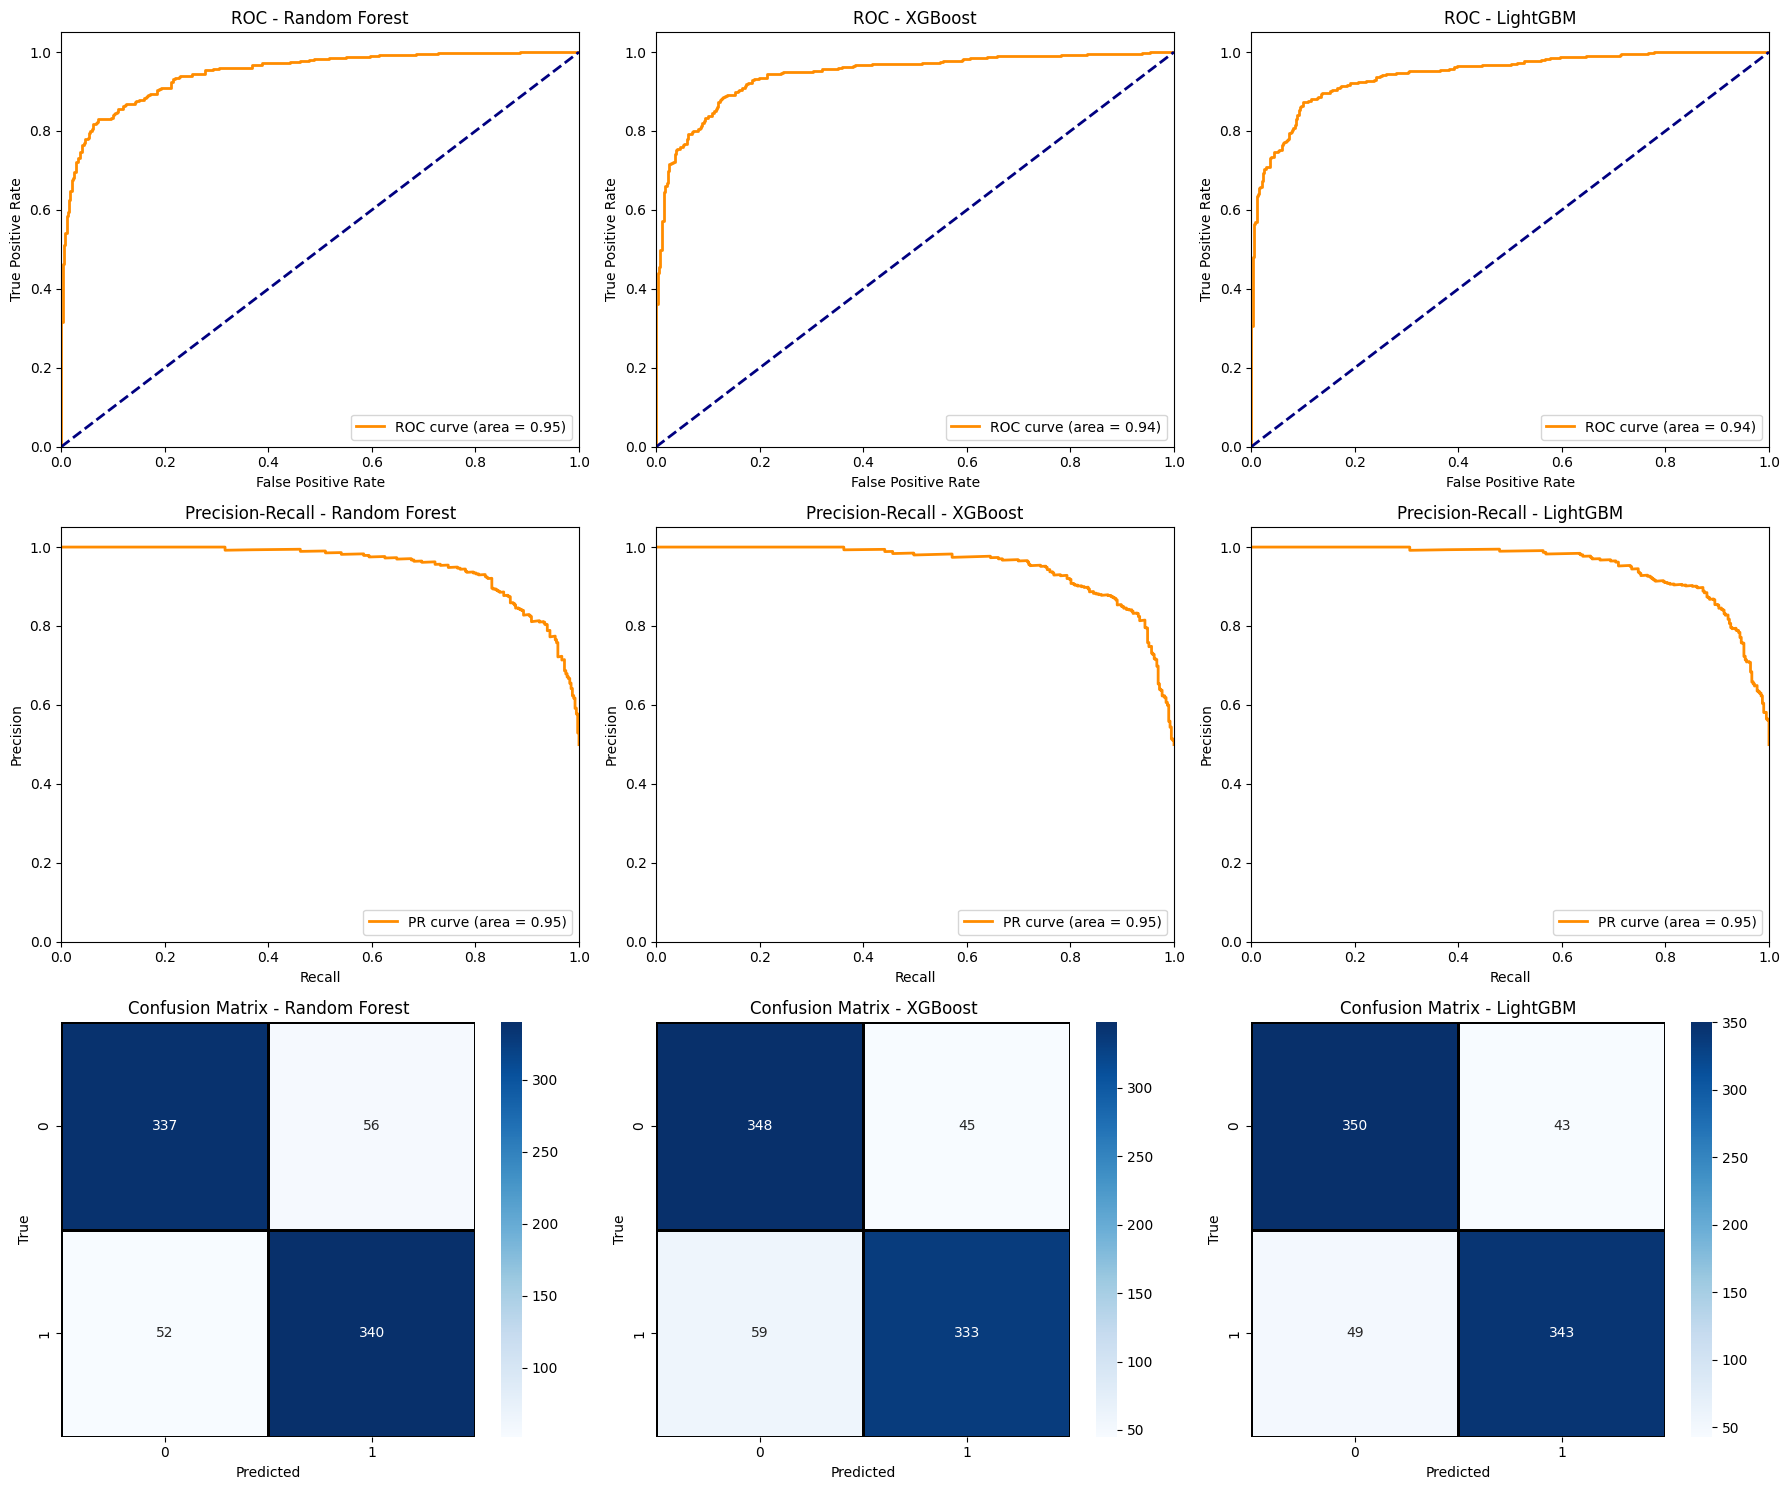

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.8624203821656051, 'Precision': 0.8585858585858586, 'Recall': 0.8673469387755102, 'F1 Score': 0.8629441624365481, 'ROC AUC': 0.9462662927766526}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.867515923566879, 'Precision': 0.8809523809523809, 'Recall': 0.8494897959183674, 'F1 Score': 0.864935064935065, 'ROC AUC': 0.9432738744352702}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.8828025477707007, 'Precision': 0.8886010362694301, 'Recall': 0.875, 'F1 Score': 0.8817480719794345, 'ROC AUC': 0.9440528119644804}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.8828025477707007,
 'Precision': 0.8886010362694301,
 'Recall': 0.875,
 'F1 Score': 0.8817480719794345,
 'ROC AUC': 0.9440528119644804}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: LightGBM with Accuracy: 0.8828


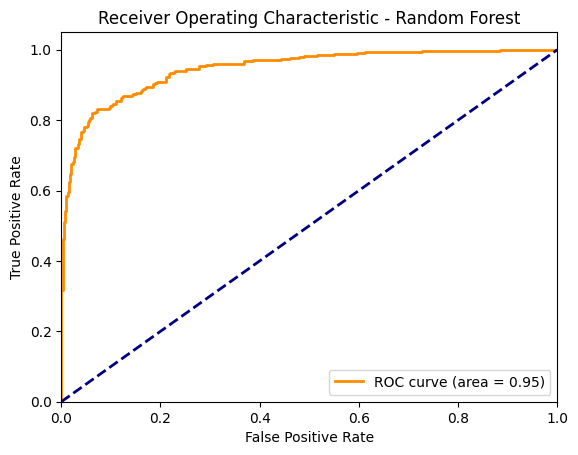

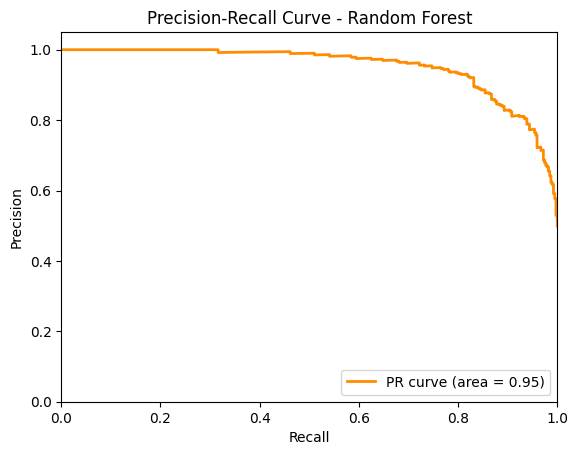

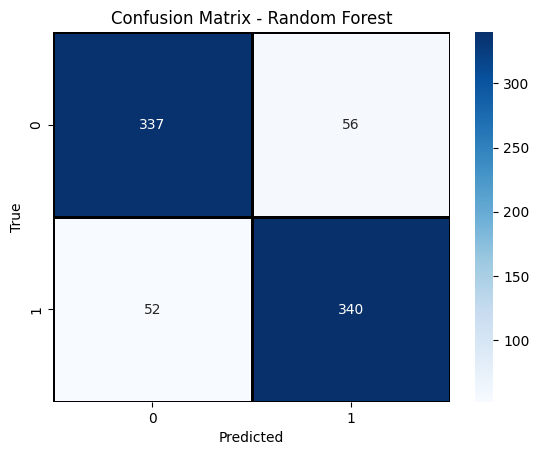

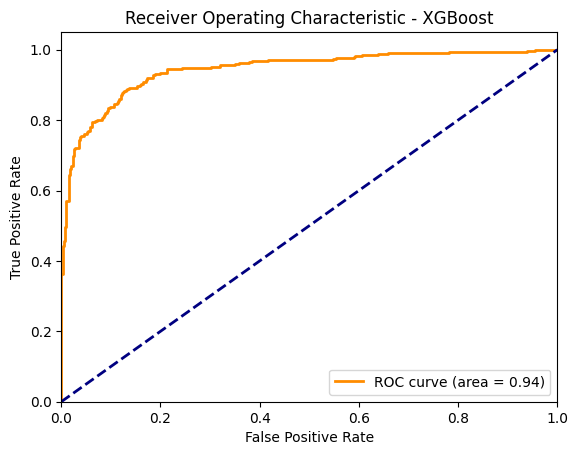

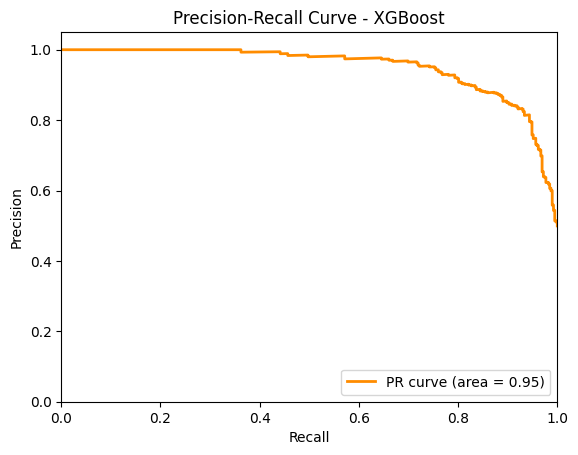

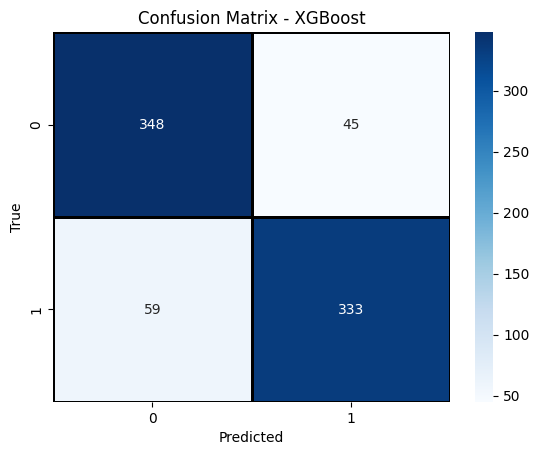

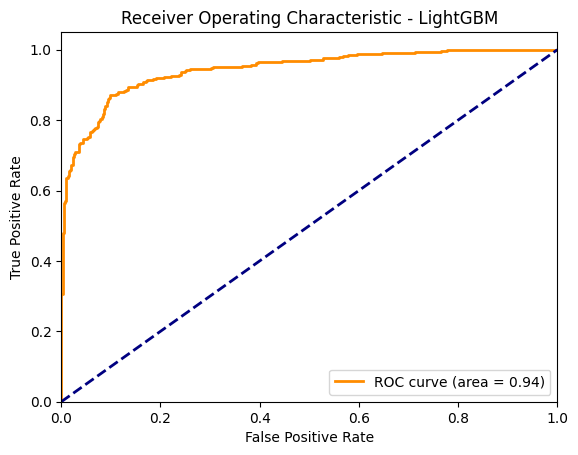

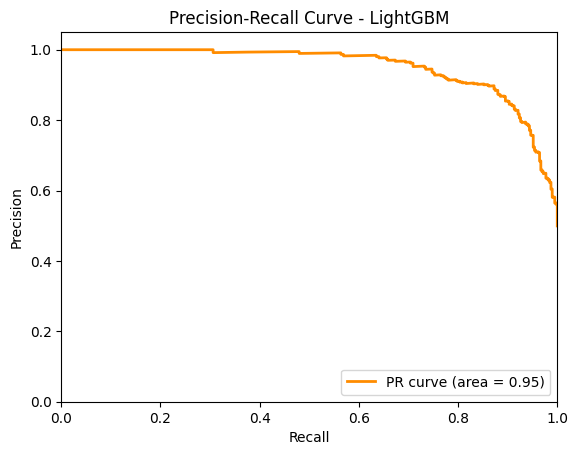

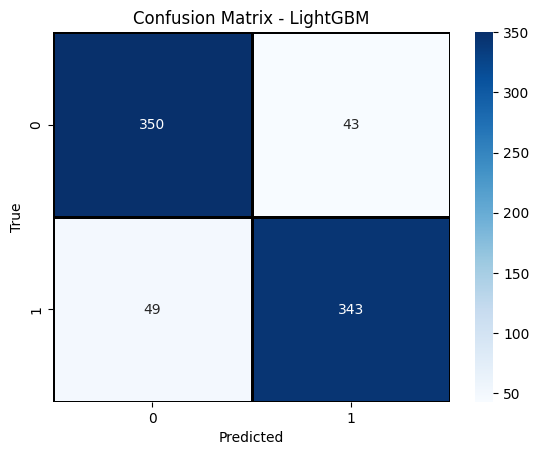

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

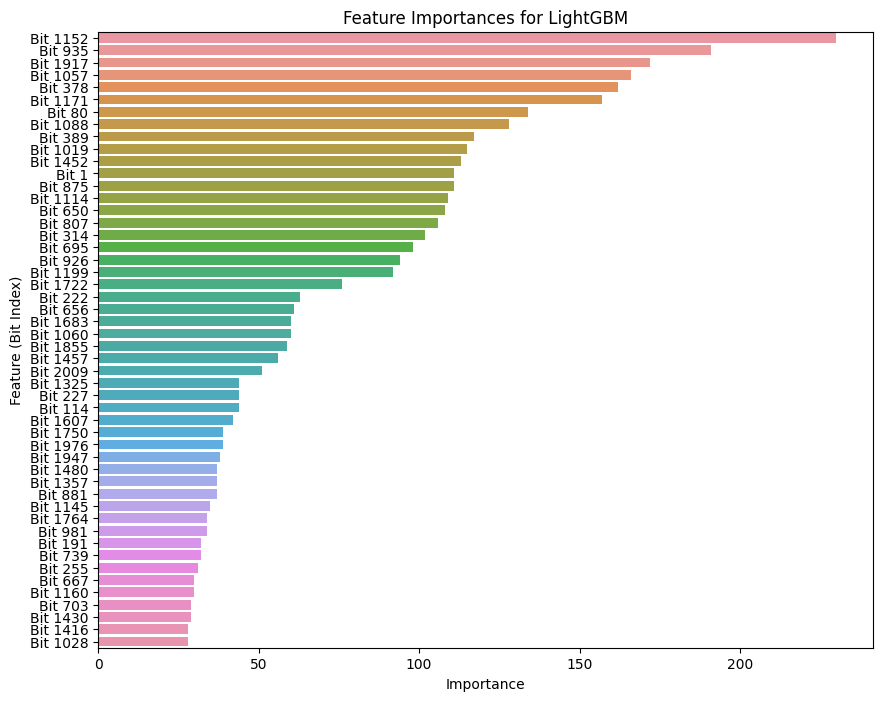

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
